In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from transformers import TrainingArguments, set_seed

from data import SharedTaskData
from models import MultitaskModel
from train_mtl import Tokenize, compute_metrics, prepare_data
from trainers import MultitaskTrainer, NLPDataCollator, TASK_NAMES

/data/volume_2/venvs/vargmining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set variables.
checkpoint: str = "hftrainer_am_mtl_../SimCSE/result/novelty-sup-simcse-sup-roberta-large-mnli/_10_1e-05_0/checkpoint-846"
use_model: str = "roberta-large-mnli"
seed: int = 0
tensorflows: bool = False

In [3]:
# Load dataset.
set_seed(seed)
tokenize = Tokenize(use_model, tensorflows, "concatenation", predict_only=False)
torch.backends.cudnn.deterministic = True

train_data = SharedTaskData("TaskA_train.csv")
dev_data = SharedTaskData("TaskA_test.csv")

tokenized_train_dataset_novelty, tokenized_dev_dataset_novelty = prepare_data(
    use_model,
    train_data,
    dev_data,
    "novelty",
    tokenize.tokenize_function_nov
)
tokenized_train_dataset_validity, tokenized_dev_dataset_validity = prepare_data(
    use_model,
    train_data,
    dev_data,
    "validity",
    tokenize.tokenize_function_val
)

if "ArgumentRelation" in use_model:
    kwargs = {'pad_token_id': 1}
else:
    kwargs = {}

# Load model.
multitask_model = MultitaskModel.create(
    model_name=use_model,
    model_type_dict={
        "novelty": transformers.AutoModelForSequenceClassification,
        "validity": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "novelty": transformers.AutoConfig.from_pretrained(use_model, num_labels=2, **kwargs),
        "validity": transformers.AutoConfig.from_pretrained(use_model, num_labels=2, **kwargs),
    },
    tensorflows=tensorflows
)

multitask_model.load_trainer_checkpoint(checkpoint)

# Load trainer/evaluator.
val_dataset = {
    "novelty": tokenized_dev_dataset_novelty,
    "validity": tokenized_dev_dataset_validity,
}

train_dataset = {
    "novelty": tokenized_train_dataset_novelty,
    "validity": tokenized_train_dataset_validity,
}

training_args = TrainingArguments(
    f"hftrainer_am_mtl_{use_model}_{seed}",
    label_names=['labels']
)

trainer = MultitaskTrainer(
    model=multitask_model,
    data_collator=NLPDataCollator(tokenizer=tokenize.tokenizer),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenize.tokenizer,
    compute_metrics=compute_metrics,
    args=training_args,
)

Parameter 'function'=<function map_label at 0x7ff42b0a5af0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51ba/s]
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. ini

In [4]:
# Get predictions on validation set.
outputs = trainer.predict(val_dataset)
# for task in TASK_NAMES:
    # print(f"{task}: Amount of mistakes: {torch.sum(outputs[task]['predictions'] != torch.tensor(outputs[task]['labels']))}")

***** Running Prediction *****
  Num examples = 520
  Batch size = 16


Predicting novelty


/data/volume_2/venvs/vargmining/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** Running Prediction *****
  Num examples = 520
  Batch size = 16


Predicting validity


/data/volume_2/venvs/vargmining/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import json

In [6]:
def print_results(predictions, true_labels):
    print(classification_report(true_labels, predictions, digits=3))
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"All correct: {tp + tn}")
    print(f"All wrong: {fp + fn}")
    print(f"All positives: {tp + fp}")
    print(f"All negatives: {tn + fn}")
    print(f"Positive: {tp+fn}")
    print(f"Negative: {fp+tn}")


MTL_output_val = np.argmax(outputs['validity'].predictions, axis=1)
MTL_output_nov = np.argmax(outputs['novelty'].predictions, axis=1)

with open('predictions/dump_prompt_5_eval=True_results.json') as f:
    data = json.load(f)
GPT_output_nov = []
for item in data:
    GPT_output_nov.append(1 if item['pred_nov'] == 'novel' else 0)
GPT_output_val = []
for item in data:
    GPT_output_val.append(1 if item['pred_val'] == 'valid' else 0)


val_true = list(dev_data.df.Validity.apply(lambda x: 1 if x == 1 else 0))
nov_true = list(dev_data.df.Novelty.apply(lambda x: 1 if x == 1 else 0))

ones = np.sum(nov_true)
print(f"NOVELTY Number of true labels {ones}")
print(f"NOVELTY Number of true labels {len(nov_true) - ones}")

print("MTL Validity")
print_results(MTL_output_val, val_true)
print("MTL Novelty")
print_results(MTL_output_nov, nov_true)
print("GPT Validity")
print_results(GPT_output_val, val_true)
print("GPT Novelty")
print_results(GPT_output_nov, nov_true)


NOVELTY Number of true labels 226
NOVELTY Number of true labels 294
MTL Validity
              precision    recall  f1-score   support

           0      0.806     0.364     0.502       206
           1      0.693     0.943     0.799       314

    accuracy                          0.713       520
   macro avg      0.750     0.653     0.650       520
weighted avg      0.738     0.713     0.681       520

TP: 296, TN: 75, FP: 131, FN: 18
All correct: 371
All wrong: 149
All positives: 427
All negatives: 93
Positive: 314
Negative: 206
MTL Novelty
              precision    recall  f1-score   support

           0      0.646     0.901     0.753       294
           1      0.736     0.358     0.482       226

    accuracy                          0.665       520
   macro avg      0.691     0.630     0.617       520
weighted avg      0.685     0.665     0.635       520

TP: 81, TN: 265, FP: 29, FN: 145
All correct: 346
All wrong: 174
All positives: 110
All negatives: 410
Positive: 226
Negati

CLTeamL-1 validity
0	0.13076923076923078	0.19038461538461537
1	0.13653846153846153	0.5153846153846153
2	0.011538461538461539	0.015384615384615385
CLTeamL-1 novelty
0	0.28846153846153844	0.2865384615384615
1	0.16153846153846155	0.25
2	0.0019230769230769232	0.011538461538461539
CLTeamL-2 validity
0	0.14038461538461539	0.18076923076923077
1	0.1326923076923077	0.5192307692307693
2	0.013461538461538462	0.013461538461538462
CLTeamL-2 novelty
0	0.24423076923076922	0.33076923076923076
1	0.09038461538461538	0.3211538461538462
2	0	0.013461538461538462


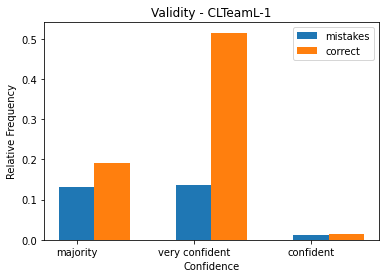

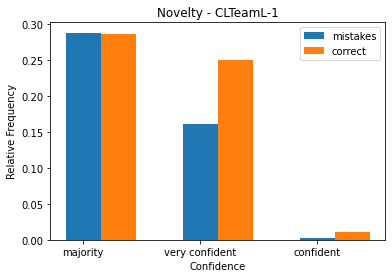

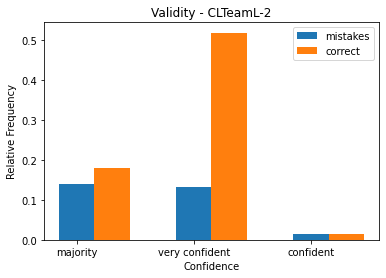

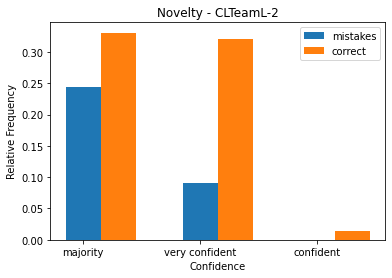

In [7]:
# Get (mis-)classification of predictions based on confidence of annotation.
%matplotlib inline

# Retrieve confidences of the mistakes and correct classifications.
def plot_confidences(predictions, labels, task, approach):
    mistakes_idxs = (np.array(predictions) != np.array(labels)).nonzero()
    confs_mistakes = dev_data.df.iloc[mistakes_idxs][f"{task.capitalize()}-Confidence"]
    correct_idxs = (np.array(predictions) == np.array(labels)).nonzero()
    confs_correct = dev_data.df.iloc[correct_idxs][f"{task.capitalize()}-Confidence"]
    # Normalize over the total count of mistakes and corrects respectively.
    confs_mistakes = {k: v / len(predictions) for k, v in confs_mistakes.value_counts().to_dict().items()}
    confs_correct = {k: v / len(predictions) for k, v in confs_correct.value_counts().to_dict().items()}
    
    # Uncomment if background is black so text of plot is white.
    plt.figure()
    params = {"ytick.color" : "black",
              "xtick.color" : "black",
              "axes.labelcolor" : "black",
              "figure.facecolor": "w",
              "axes.edgecolor" : "black"}
    plt.rcParams.update(params)

    np.random.seed(0)
    plt.title(f"{task.capitalize()} - {approach}", color='black')
    xticks = [0,1,2]
    xticklabels = ["majority", "very confident", "confident"]
    plt.xticks(xticks, xticklabels)
    plt.xlabel('Confidence')
    plt.ylabel('Relative Frequency')
    plt.title(f"{task.capitalize()} - {approach}", color='black')

    width = 0.3
    xs = np.array(xticks)
    ys_mistakes = [confs_mistakes.get(k, 0) for k in xticklabels]
    ys_correct = []
    ys_correct = [confs_correct[k] for k in xticklabels]
    plt.bar(xs, ys_mistakes, label="mistakes", width=width)
    plt.bar(xs + width, ys_correct, label="correct", width=width)
    plt.legend()
    plt.savefig(f"confidence_{approach}_{task}.png")
    
    print(approach, task)
    for i in xs:
        print(f"{i}\t{ys_mistakes[i]}\t{ys_correct[i]}")


plot_confidences(GPT_output_val, val_true, "validity", "CLTeamL-1")
plot_confidences(GPT_output_nov, nov_true, "novelty", "CLTeamL-1")

plot_confidences(MTL_output_val, val_true, "validity", "CLTeamL-2")
plot_confidences(MTL_output_nov, nov_true, "novelty", "CLTeamL-2")


In [8]:
# Get distribution of mistakes over combined labels.

def get_mistake_dist(predictions, labels, task, approach):
    idxs = (np.array(predictions) != np.array(labels)).nonzero()
    val_mistakes = dev_data.df.iloc[idxs]["Validity"]
    nov_mistakes = dev_data.df.iloc[idxs]["Novelty"]

    counts = defaultdict(int)
    for val_mistake, nov_mistake in zip(val_mistakes, nov_mistakes):
        if val_mistake == -1 and nov_mistake == -1:
            counts["non-valid;non-novel"] += 1
        elif val_mistake == 1 and nov_mistake == -1:
            counts["valid;non-novel"] += 1
        elif val_mistake == -1 and nov_mistake == 1:
            counts["non-valid;novel"] += 1
        elif val_mistake == 1 and nov_mistake == 1:
            counts["valid;novel"] += 1

    counts = {k: v / len(val_mistakes) for k, v in counts.items()}
    print(approach)
    print(counts)


get_mistake_dist(GPT_output_val, val_true, "validity", "CLTeamL-1")
get_mistake_dist(GPT_output_nov, nov_true, "novelty", "CLTeamL-1")

get_mistake_dist(MTL_output_val, val_true, "validity", "CLTeamL-2")
get_mistake_dist(MTL_output_nov, nov_true, "novelty", "CLTeamL-2")

CLTeamL-1
{'non-valid;non-novel': 0.31724137931034485, 'non-valid;novel': 0.27586206896551724, 'valid;non-novel': 0.2206896551724138, 'valid;novel': 0.18620689655172415}
CLTeamL-1
{'valid;novel': 0.4553191489361702, 'non-valid;non-novel': 0.1148936170212766, 'valid;non-novel': 0.1148936170212766, 'non-valid;novel': 0.3148936170212766}
CLTeamL-2
{'non-valid;novel': 0.4563758389261745, 'valid;novel': 0.11409395973154363, 'non-valid;non-novel': 0.4228187919463087, 'valid;non-novel': 0.006711409395973154}
CLTeamL-2
{'valid;novel': 0.45977011494252873, 'non-valid;non-novel': 0.09770114942528736, 'valid;non-novel': 0.06896551724137931, 'non-valid;novel': 0.3735632183908046}


In [9]:
# Get percentage of mistakes per topic.
def get_pct_mistakes(predictions, labels, task, approach):
    idxs = (np.array(predictions) != np.array(labels)).nonzero()
    topics_mistakes = dev_data.df.iloc[idxs]["topic"]

    topic_results = topics_mistakes.value_counts() / dev_data.df["topic"].value_counts()
    print(f"== {approach} - {task} ==")
    print(topic_results)

print("Score is percentage of mistakes per topic.")
get_pct_mistakes(GPT_output_val, val_true, 'validity', "CLTeamL-1")
get_pct_mistakes(GPT_output_nov, nov_true, 'novelty', "CLTeamL-1")

get_pct_mistakes(MTL_output_val, val_true, 'validity', "CLTeamL-2")
get_pct_mistakes(MTL_output_nov, nov_true, 'novelty', "CLTeamL-2")

Score is percentage of mistakes per topic.
== CLTeamL-1 - validity ==
Veal                                            0.216216
Vegetarianism                                   0.080000
Video games                                          NaN
Video surveillance                              0.250000
War on Drugs                                    0.264151
Warrantless wiretapping in the United States    0.148148
Was the War in Iraq worth it?                   0.448276
Water privatization                             0.244898
Wave power                                      0.125000
Wind energy                                     0.120000
Withdrawing from Iraq                           0.380597
Year-round school                               0.396552
Yucca Mountain nuclear waste repository         0.375000
Zero tolerance law                              0.210526
Zoos                                                 NaN
Name: topic, dtype: float64
== CLTeamL-1 - novelty ==
Veal                 